## Import dependencies


In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

import seaborn as sns

## Read data

In [8]:
X_train = pd.read_csv("../data/train_test_val/X_train.csv", header=[0,1], index_col=0)
X_test = pd.read_csv("../data/train_test_val/X_test.csv", header=[0,1], index_col=0)
X_val = pd.read_csv("../data/train_test_val/X_val.csv", header=[0,1], index_col=0)

y_train = pd.read_csv("../data/train_test_val/y_train.csv", index_col=0) 
y_val = pd.read_csv("../data/train_test_val/y_val.csv", index_col=0)
y_test = pd.read_csv("../data/train_test_val/y_test.csv", index_col=0)

### Creating ML Pipeline

In [9]:
rfc = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42)
knc = KNeighborsClassifier()
abc = AdaBoostClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
gnb = GaussianNB()
lr = LogisticRegressionCV(max_iter=500, random_state=42)

models = {"rfc": rfc,"svc": svc, "knc" : knc,
          "abc" : abc, "gbc" : gbc, "gnb" :gnb,
          "lr": lr}

In [10]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train.drop("id_gps", axis=1)) 
scaled_X_val = scaler.fit_transform(X_val.drop("id_gps", axis=1))
scaled_X_test = scaler.fit_transform(X_test.drop("id_gps", axis=1))

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [11]:
X_train = X_train.drop("id_gps", axis = 1)
X_val = X_val.drop("id_gps", axis = 1)
X_test = X_test.drop("id_gps", axis = 1)
y_train = y_train.values.reshape(-1)
y_val = y_val.values.reshape(-1)
y_test = y_test.values.reshape(-1)


c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
for m in models:
    
    model = models[m].fit(scaled_X_train, y_train)
    preds = model.predict(scaled_X_val)
      
    accuracy = accuracy_score(y_val,preds)
    precision = precision_score(y_val,preds,average="weighted")
    recall = recall_score(y_val,preds, average="weighted")
    f1 = f1_score(y_val, preds, average="weighted")
    
    print("Metrics on Validation Dataset:")
    print("\n")
    
    print(f"Accuracy {m}: {accuracy}")
    print(f"Precision {m}: {precision}")
    print(f"Recall {m}: {recall}")
    print(f"F1 Score {m}: {f1}")
    
    print("\n")
    print("Cross Validation on Test Dataset:")
    print("\n")
    cv = cross_validate(model,
                        X =  scaled_X_test,
                        y = np.ravel(y_test),
                        cv = 6)

    print("{} accuracy is {:.2f}±{:.2f}".format(m,cv["test_score"].mean()*100,cv["test_score"].std()*100))

    
    print("\n")
    print("Test Scores:\n min: {}\n max: {}\n delta: {}"\
          .format(cv["test_score"].min(), 
                  cv["test_score"].max(),
                  cv["test_score"].max()-cv["test_score"].min()))
    print("\n")
    print("*"*20)
    print("\n")
    
    cm = confusion_matrix(y_val,preds)
    
    fig = plt.figure()
    fig = plt.title(m)
    sns.heatmap(cm, cmap="viridis", annot= True, cbar = False)

Metrics on Validation Dataset:


Accuracy rfc: 0.9173333333333333
Precision rfc: 0.9168289177489177
Recall rfc: 0.9173333333333333
F1 Score rfc: 0.9170202123899568


Cross Validation on Test Dataset:


rfc accuracy is 92.76±2.44


Test Scores:
 min: 0.9069767441860465
 max: 0.9767441860465116
 delta: 0.06976744186046513


********************


Metrics on Validation Dataset:


Accuracy svc: 0.8853333333333333
Precision svc: 0.8833313296903461
Recall svc: 0.8853333333333333
F1 Score svc: 0.8833617495656596


Cross Validation on Test Dataset:


svc accuracy is 89.69±2.18


Test Scores:
 min: 0.8636363636363636
 max: 0.9318181818181818
 delta: 0.06818181818181812


********************


Metrics on Validation Dataset:


Accuracy knc: 0.8533333333333334
Precision knc: 0.8576983012306045
Recall knc: 0.8533333333333334
F1 Score knc: 0.8492427972898562


Cross Validation on Test Dataset:


knc accuracy is 90.08±5.02


Test Scores:
 min: 0.8181818181818182
 max: 0.9772727272727273
 delta: 0.15

The best results belongs to the RandomForest Classifier, but the KNC results are promising as well.

#### Logistic Regression

In [211]:
lr.fit(scaled_X_train, y_train)

LogisticRegressionCV(max_iter=500, random_state=42)

#### GBC

In [182]:
gbc.fit(scaled_X_train, y_train)

GradientBoostingClassifier(random_state=42)

#### RFC

In [217]:
rfc.fit(scaled_X_train, y_train)

RandomForestClassifier(random_state=42)

## Hyperparameter tuning

In [218]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {
        "min_samples_leaf": [1,2,3 ,4, 8,16,20],
        "min_samples_split": [2, 4, 8, 12],
        "n_estimators": [100, 400, 800,1200]
}

rfc_search = RandomizedSearchCV(rfc, 
                                params, 
                                n_iter=36,
#                                 average = "weighted",
                                scoring="recall_weighted",
                                random_state=42)

rfc_search.fit(scaled_X_train, y_train)

In [219]:
# best_model = rfc_search.best_estimator_
preds = rfc.predict(scaled_X_test)
accuracy = accuracy_score(y_test,preds)
precision = precision_score(y_test,preds,average="weighted")
recall = recall_score(y_test,preds, average="weighted")
f1 = f1_score(y_test, preds, average="weighted")

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9045226130653267
Precision: 0.9170963751217963
Recall: 0.9045226130653267
F1 Score: 0.9043982310737894


### Cross Validation

In [220]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

In [221]:
cv = cross_validate(rfc,
               X =  scaled_X_test,
               y = np.ravel(y_test))

print("Model accuracy is {:.2f}±{:.2f}".format(cv["test_score"].mean()*100,cv["test_score"].std()*100))
print(cv)

Model accuracy is 89.46±2.88
{'fit_time': array([0.2898345 , 0.24485731, 0.28283715, 0.30581975, 0.26085281]), 'score_time': array([0.01299381, 0.01199555, 0.02798486, 0.01199365, 0.01400733]), 'test_score': array([0.9       , 0.925     , 0.875     , 0.85      , 0.92307692])}


In [222]:
cm = confusion_matrix(y_test,preds)

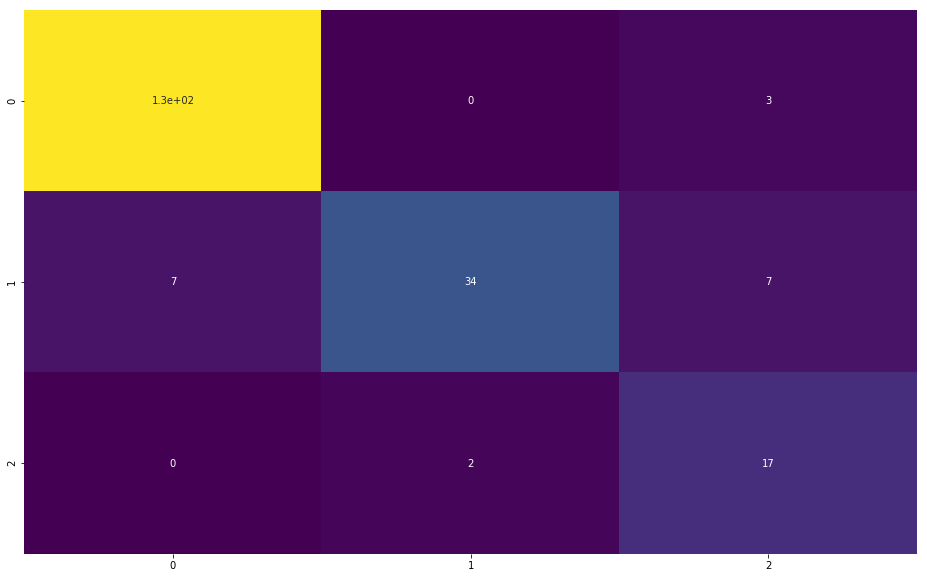

In [223]:
sns.heatmap(cm, cmap="viridis", annot= True, cbar = False)

## Save the model

In [266]:
from joblib import dump, load
dump(svc, '../models/svc_v01.joblib') 

['../models/svc_v01.joblib']

## Eval


In [226]:
from processing_funcs import *
from scipy.stats import norm, kurtosis
from scipy import signal

In [272]:
df = read_measurement("../data/raw_data_train/rsq_q2/*", 0.01)

In [273]:
def kurtosis_time(x):

    return kurtosis(x, fisher=True)

def rms_100(x):

    return np.sqrt(np.mean(x**2))

def crest(x):

    return max(abs(x))/np.sqrt(np.mean(x**2))

def create_aggregated(df):
    """Create a aggregated dataframe in time domain"""
    signals = ['x_lin_acc', 'y_lin_acc', "z_lin_acc", 
               'x_acc', 'y_acc', 'z_acc',
               'x_gyro', 'y_gyro', 'z_gyro']

    agg_df = df.groupby(["id_gps"]).agg({x: ["sum", "mean", "mad",
                                                "median", "min", "max",
                                                "std", "var", "sem",
                                                "skew", "quantile",
                                                kurtosis_time, rms_100,
                                                crest] for x in signals})

    return agg_df

In [274]:
feature_df = create_aggregated(df).reset_index()

In [275]:
scaler = StandardScaler()
scaled = scaler.fit_transform(feature_df.drop("id_gps", axis=1)) 

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

